In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline

/home/brijml/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_random(size):
    return np.random.normal(4,3,size=size)

4.036725542385525

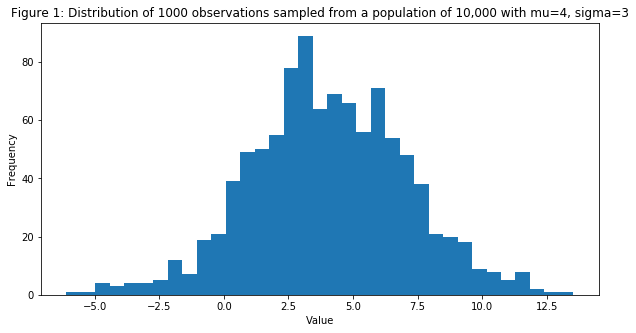

In [3]:
rand_pts = get_random(size=10000)
observation = rand_pts[np.random.randint(0,10000,1000)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 10,000 with mu=4, sigma=3")
mu_obs = observation.mean()
mu_obs

In [4]:
def proposal_dist(sigma):
    return np.random.normal(sigma, 0.5)

def prior(sample):
    if sample<=0: 
        return 0
    return 1

In [5]:
def log_likelihood(data, mu, sigma):
    return np.sum(-np.log(sigma * np.sqrt(2*np.pi)) - ((data - mu)**2)/(2*sigma**2))

In [6]:
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

In [7]:
sigma = 0.1
iterations = 50000
accepted, rejected = [],[]
for i in range(iterations):
    sigma_cand = proposal_dist(sigma)
    old_likelihood = log_likelihood(observation, mu_obs, sigma)
    new_likelihood = log_likelihood(observation, mu_obs, sigma_cand)
    if (acceptance(old_likelihood + np.log(prior(sigma)), new_likelihood+np.log(prior(sigma_cand)))):
        sigma = sigma_cand
        accepted.append(sigma_cand)
    else:
        rejected.append(sigma_cand)

In [8]:
len(accepted), len(rejected)

(8433, 41567)

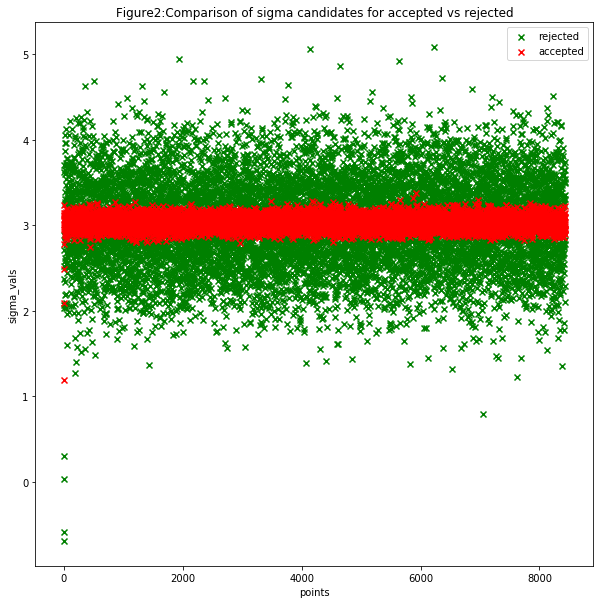

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('points')
ax.set_ylabel('sigma_vals')
ax.set_title('Figure2:Comparison of sigma candidates for accepted vs rejected')
p1 = ax.scatter(range(len(accepted)),rejected[0:len(accepted)],color='g',marker='x')
p2 = ax.scatter(range(len(accepted)),accepted,color='r',marker='x')
ax.legend((p1,p2), ('rejected', 'accepted'))

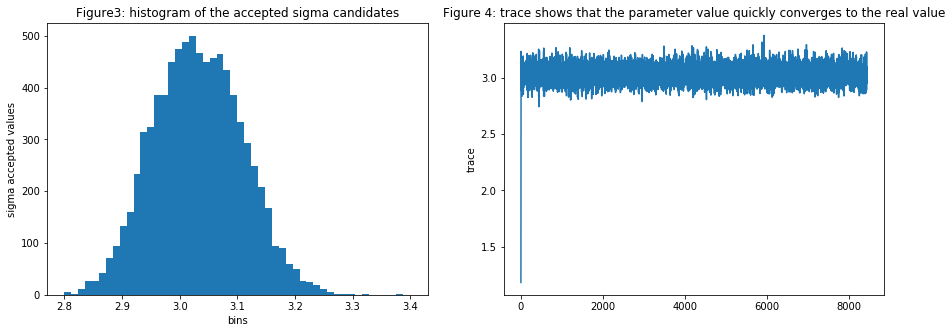

In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel('bins')
ax.set_ylabel('sigma accepted values')
ax.set_title('Figure3: histogram of the accepted sigma candidates')
hist = ax.hist(accepted, bins=50, range=(2.8,3.4))

ax = fig.add_subplot(1,2,2)
ax.set_title('Figure 4: trace shows that the parameter value quickly converges to the real value')
ax.set_ylabel('trace')
p1 = ax.plot(accepted)

In [14]:
with pm.Model() as basic_model:
    
    #priors
    mu_model = pm.Normal('mean', mu=0, sigma=1)
    sigma_model = pm.HalfNormal('sigma', sigma=1)
    
    #Likelihood
    proposal_dist = pm.Normal('proposal_dist', mu=mu_model, sigma=sigma_model, observed=observation)
        
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Draw the specified number of samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:02<00:00, 3798.43draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d5de92b70>,
      dtype=object)

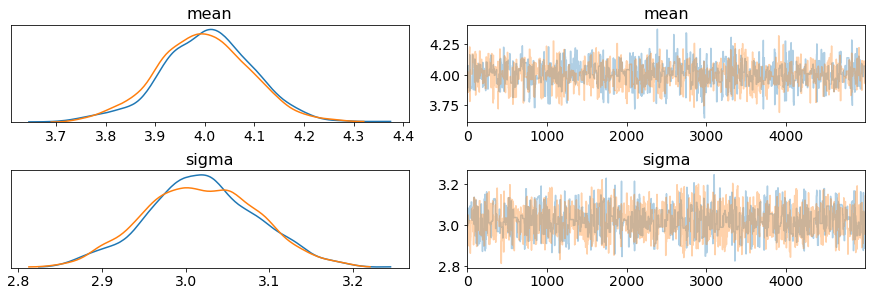

In [15]:
pm.traceplot(trace)